In [502]:
#Imports
# import os
# os.environ['NUMEXPR_MAX_THREADS'] = 40
import numpy as np
import random
from time import time
from tmu.models.classification.vanilla_classifier import TMClassifier
from scipy.sparse import lil_matrix
from skimage.util import view_as_windows
from sklearn.feature_extraction.text import CountVectorizer
import cv2
from skimage.transform import pyramid_gaussian, pyramid_laplacian, downscale_local_mean
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt #drawing plots
import matplotlib.patches as patches #drawing squares
from matplotlib.lines import Line2D
from scipy.ndimage import rotate
import math 


import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

from tqdm import tqdm #runtime stats

import ssl

ssl._create_default_https_context = ssl._create_unverified_context
from keras.datasets import cifar10


In [503]:

#Parameters

#TM
epochs = 20
max_included_literals = 500
clauses = 10
T = int((np.sqrt(clauses)/2 + 2)*10)
s = 1.5
step = 1

#Data
trained_labels = np.array([1,2])
#trained_labels = np.arange(4)
training_pool_size = 50 # number of testing pictures loaded

#preprocessing
resolution = 2 # scaled colors to thermometer code size of..
patch_dim = [3,3]

# Dice Dataset parameters
use_debug_dataset = True
train_size = training_pool_size
test_size = 50
window_top_left = (0, 0)
window_bottom_right = (32, 32)
dice_size = 20

# Second run parameters
bypass_anchor_selection = True
n_anchor_points = 3 #if bypass, then only one selected

        

In [504]:
# Debug dataset creation function
def dice_image(value, top_left=(0, 0), bottom_right=(32, 32), dice_size=8, rand_placement=False, rotation_angle=None):
    img = np.zeros((32, 32, 3), dtype=np.uint32)
    
    # Relative dot size
    dot_size = dice_size // 6
    if dot_size<1:dot_size=1
    
    dot_color = (255, 0, 0)  # Red color
    dot_color = (255, 255, 255)  # Red color
    
    if value not in range(0, 10):
        raise ValueError("Dice value should be between 0 and 10.")

    
    # Relative positions for the center of dice based on its value and dice size
    offset = dice_size // 4
    positions = {
        4: [(-offset, -offset)],
        5: [(-offset, -offset), (offset, offset)],
        3: [(-offset, -offset), (0, 0), (offset, offset)],
        1: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset)],
        2: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0)],
        6: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, -offset), (0, offset)],
        7: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0), (0, -offset), (0, offset)],
        8: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, -offset), (0, offset), (-offset, 0), (offset, 0)],
        9: [(-offset, -offset), (-offset, offset), (offset, -offset), (offset, offset), (0, 0), (0, -offset), (0, offset), (-offset, 0), (offset, 0)]
    }
    if rand_placement:
        # Generate a random position within the window for the center of the dice
        center_x = random.randint(top_left[0] + dice_size // 2, bottom_right[0] - dice_size // 2)
        center_y = random.randint(top_left[1] + dice_size // 2, bottom_right[1] - dice_size // 2)
    else:
        center_y = bottom_right[1] - top_left[1]
        center_x = bottom_right[0] - top_left[0]
    if value != 0:
        for pos in positions[value]:
            x = center_x + pos[0]
            y = center_y + pos[1]
            img[y-dot_size//2:y+dot_size//2, x-dot_size//2:x+dot_size//2] = dot_color

    # Rotation logic
    if rotation_angle is not None:
        if rotation_angle in [90, 180, 270]:
            img = np.rot90(img, k=rotation_angle // 90)
        else:
            img = rotate(img, rotation_angle, reshape=False, mode='nearest')

    return img, center_x, center_y

16 22
2024-01-05 20:45:23,139 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
13 19
2024-01-05 20:45:23,140 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
15 19
2024-01-05 20:45:23,142 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
14 21
2024-01-05 20:45:23,144 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
16 15
2024-01-05 20:45:23,146 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22 18
22 19
20 18
15 21


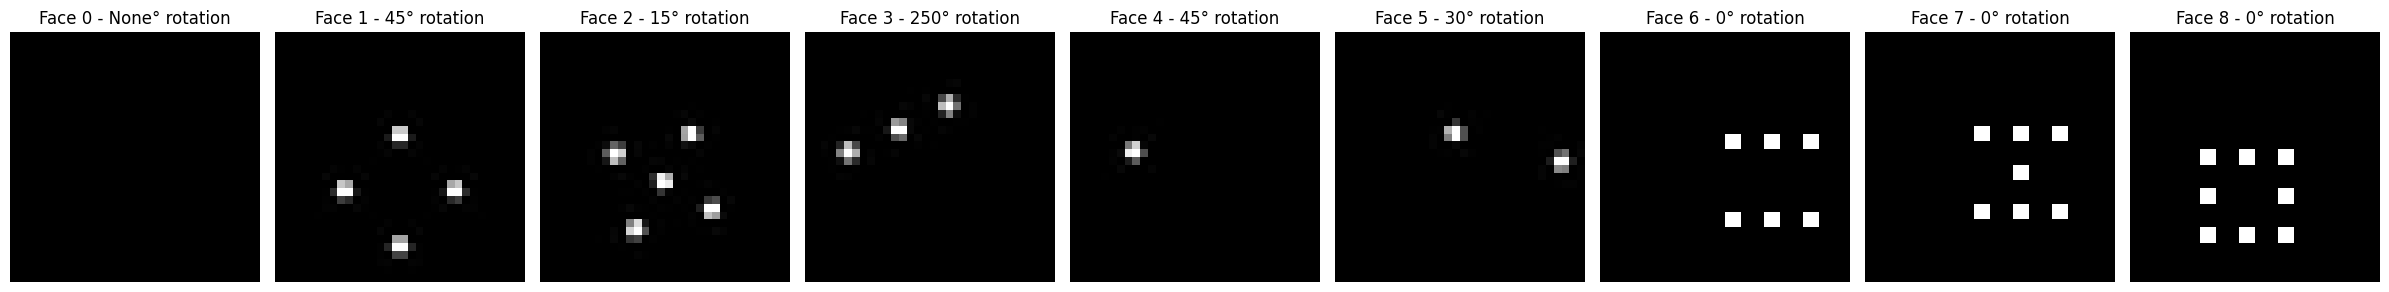

In [505]:
# Testing the dice_image function
# Plotting the dice faces with random positions and rotations within the specified window
fig, axes = plt.subplots(1, 9, figsize=(24, 4))

rotations = [None, 45, 15, 250, 45, 30, 0, 0, 0 ,0]  # Some sample rotations

for ax, value, rot in zip(axes, range(0, 11), rotations):
    img, auxX, auxY = dice_image(value, window_top_left, window_bottom_right, dice_size, True, rot)
    ax.imshow(img)
    print(auxX, auxY)
    ax.axis("off")
    ax.set_title(f"Face {value} - {rot}° rotation")

plt.tight_layout()
plt.show()

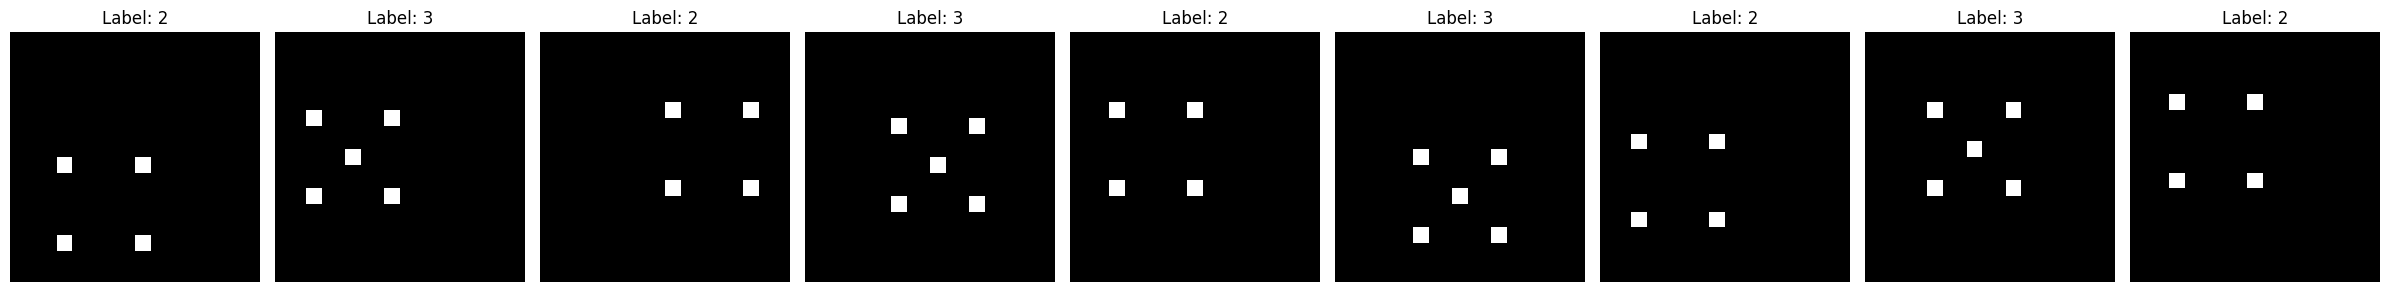

Dataset size:
(50, 32, 32, 3)
(50,)
(50, 32, 32, 3)
(50,)


In [506]:

if use_debug_dataset: # Dataset selection
    def generate_debug_dataset(dataset_size, window_top_left, window_bottom_right, dice_size, random_rotations=False, include_random_class=False, random_placement=False):
        dataset = np.zeros((dataset_size, 32, 32, 3), dtype=np.uint32)
        labels = np.zeros((dataset_size,), dtype=np.uint32)
        dice_coordinates = np.zeros((dataset_size,2), dtype=np.uint32)
        
        #rotations = [None, 90, 180, 270]
        rotations = [None, 90, 180, 270]
        if not random_rotations:
            rotations = [None]
        
        for i in range(dataset_size):
            dice_val = trained_labels[(i % len(trained_labels))]
            rot = random.choice(rotations)
            # If the random class is to be included and the current index is for the random class
            if include_random_class and dice_val == 10:
                # Create a random pixel image
                dataset[i] = np.random.randint(0, 256, (32, 32, 3), dtype=np.uint32)
                labels[i] = 10  # The label for the random class
            else:
                # Create a dice image
                dataset[i], dice_coordinates[i, 0], dice_coordinates[i, 1] = dice_image(value=dice_val, top_left=window_top_left, bottom_right=window_bottom_right, dice_size=dice_size, rotation_angle=rot, rand_placement=random_placement)
                labels[i] = dice_val  # Making labels 0-indexed
        
        return dataset, labels, dice_coordinates

    

    # Generate datasets
    X_train_org, Y_train_org, coors_train_org = generate_debug_dataset(
        train_size,
        window_top_left,
        window_bottom_right,
        dice_size,
        include_random_class=False,
        random_rotations=False,
        random_placement=True)
    
    X_test_org, Y_test_org, coors_test_org = generate_debug_dataset(
        test_size, 
        window_top_left, 
        window_bottom_right, 
        dice_size, 
        include_random_class=False,
        random_rotations=False, 
        random_placement=True)

    # Display some sample images from the training set
    fig, axes = plt.subplots(1, 9, figsize=(24, 4))
    for i in range(9):
        ax = axes[i]
        ax.imshow(X_train_org[i])
        ax.axis("off")
        ax.set_title(f"Label: {Y_train_org[i]+1}")

    plt.tight_layout()
    plt.show()
    labels = ["Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]
    
else:

    #Load cifar10
    (X_train_org, Y_train_org), (X_test_org, Y_test_org) = cifar10.load_data()
    labels = ["Airplane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]


    #adjust to train pool size
    X_test_org = X_test_org[0:training_pool_size]
    Y_test_org = Y_test_org.reshape(Y_test_org.shape[0])[0:training_pool_size]
    X_train_org = X_train_org[0:training_pool_size]
    Y_train_org = Y_train_org.reshape(Y_train_org.shape[0])[0:training_pool_size]

    #filter only desired labels
    X_train_org = X_train_org[np.in1d(Y_train_org, trained_labels)]
    Y_train_org = Y_train_org[np.in1d(Y_train_org, trained_labels)]

X_test_org = X_test_org[np.in1d(Y_test_org, trained_labels)]
Y_test_org = Y_test_org[np.in1d(Y_test_org, trained_labels)]
print("Dataset size:")
print(X_train_org.shape)
print(Y_train_org.shape)
print(X_test_org.shape)
print(Y_test_org.shape)

In [507]:
# Thermometer coding

def thermometer_encode(image, resolution=8, prevMin=0, prevMax=255):
    # Get the shape of the input image
    shape = image.shape
    
    # Initialize the thermometer encoded image array
    encoded_image = np.zeros(shape + (resolution,), dtype=np.uint32)
    
    # Perform thermometer encoding for each color channel
    scale_factor = (prevMax - prevMin) / (resolution + 1)
    for z in range(resolution):
        encoded_image[..., z] = image >= prevMin + (z + 1) * scale_factor
    encoded_image = encoded_image.astype(np.uint32)
    return encoded_image

def thermometer_decode(encoded_image, resolution, toMin=0, toMax=255):
    # Sum along the last dimension and scale back to the original range for each color channel
    scale_factor = (toMax - toMin) / (resolution + 1)
    decoded_image = toMin + np.sum(encoded_image, axis=-1) * scale_factor
    
    # Cast the decoded image to uint8 data type
    decoded_image = decoded_image.astype(np.uint32)
    
    return decoded_image


In [508]:
def test_ThermEncodeAndDecode(original_image, thermometer_encode, thermometer_decode, resolution):
    # Encode the original image
    encoded_image = thermometer_encode(original_image, resolution)
    print(encoded_image[0])
    # Decode the encoded image back to the original form
    decoded_image = thermometer_decode(encoded_image, resolution)

    # Visualization
    plt.figure(figsize=(20, 7))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(decoded_image)
    plt.title('Decoded Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    print("original shape:", original_image.shape)
    print("original dtype:", original_image.dtype)
    print("encoded shape:", encoded_image.shape)
    print("encoded dtype:", encoded_image.dtype)
    print("decoded: shape", decoded_image.shape)
    print("decoded: dtype", decoded_image.dtype)
# Call the test function
#test_ThermEncodeAndDecode(np.full((32,32,3),223, dtype=np.uint32), thermometer_encode, thermometer_decode, 4)


In [509]:
def reshape_and_pad_dataset(dataset, target_dim_count, max_sizes):
    """Reshape and pad the dataset to have the target number of dimensions and sizes."""
    reshaped_dataset = dataset
    # Add new dimensions if necessary
    while len(reshaped_dataset.shape) < target_dim_count:
        reshaped_dataset = np.expand_dims(reshaped_dataset, axis=-1)
    
    # Pad each dimension as necessary
    padding = [(0, max_sizes[i] - reshaped_dataset.shape[i]) for i in range(len(max_sizes))]
    padded_dataset = np.pad(reshaped_dataset, padding, mode='constant', constant_values=0)
    
    return padded_dataset

def create_windowed_dataset(*datasets, patch_dim):
    if len(datasets) == 0:
        raise ValueError("At least one dataset must be provided")

    # Determine the maximum number of dimensions and sizes among all datasets
    max_dims = max(len(dataset.shape) for dataset in datasets)
    max_sizes = [max([dataset.shape[i] if i < len(dataset.shape) else 1 for dataset in datasets]) for i in range(max_dims)]

    # Reshape and pad datasets to have the same number of dimensions and sizes
    reshaped_padded_datasets = [reshape_and_pad_dataset(dataset, max_dims, max_sizes) for dataset in datasets]

    # Validate the shapes of the datasets
    common_shape = reshaped_padded_datasets[0].shape[:3]
    for dataset in reshaped_padded_datasets:
        if dataset.shape[:3] != common_shape:
            raise ValueError(f"All datasets must have the same num_images, height, and width. Expected shape: {common_shape}, but got {dataset.shape[:3]}")

    # Concatenate all datasets along the last dimension
    concatenated_dataset = np.concatenate(reshaped_padded_datasets, axis=-1)

    # Calculate and create the windowed dataset
    num_images, height, width, *data_dims = concatenated_dataset.shape
    windowed_shape = (num_images, height - patch_dim[0] + 1, width - patch_dim[1] + 1, patch_dim[0] * patch_dim[1] * np.prod(data_dims))
    windowed_dataset = np.zeros(windowed_shape, dtype=concatenated_dataset.dtype) #TODO: should be a np.array, not a touple

    for i in range(num_images):
        for y in range(height - patch_dim[0] + 1):
            for x in range(width - patch_dim[1] + 1):
                patch = concatenated_dataset[i, y:y + patch_dim[0], x:x + patch_dim[1], :]
                windowed_dataset[i, y, x, :] = patch.reshape(-1)

    return windowed_dataset

In [510]:
#Create windows
X_train = create_windowed_dataset(thermometer_encode(X_train_org, resolution=7), patch_dim=patch_dim)
X_test = create_windowed_dataset(thermometer_encode(X_test_org, resolution=7), patch_dim=patch_dim)

Y_train = Y_train_org
Y_test  = Y_test_org



In [511]:
#Train the TM 1 and record results
#f = open("run_%.1f_%d_%d_%d_%d_%d.txt" % (s, clauses, T, step, visual_tokens), "w+")
logTrain = np.zeros((epochs, X_train.shape[0]), dtype=np.uint8)
logTest =  np.zeros((epochs, X_test.shape[0]),  dtype=np.uint8)

print("Training:")
training_data_labels = np.unique(Y_train)
print(training_data_labels.shape[0], "labels used:", training_data_labels)
print("Training pictures:", X_train.shape[0])

print("Testing:")
testing_data_labels = np.unique(Y_test)
print(testing_data_labels.shape[0], "labels used:", testing_data_labels)
print("Maximum achievable accuracy:", (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
print("..adjusting") #see result_test_adj
print("Testing pictures:", X_test.shape[0])

for label in range(trained_labels.shape[0]):
        print("\nAccuracy over %d epochs:\n" % (epochs))

        tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(1,1), platform='CPU', weighted_clauses=True)
        
        for epoch in tqdm(range(epochs)):
                start_training = time()
                tm.fit(X_train, Y_train)
                stop_training = time()

                start_testing = time()
                result_test = 100*(tm.predict(X_test) == Y_test).mean()
                result_test_adj = 100*(result_test/ (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
                logTest[epoch] = (tm.predict(X_test))*label
                stop_testing = time()

                result_train = 100*(tm.predict(X_train) == Y_train).mean()
                logTrain[epoch] = (tm.predict(X_train))*label

                #recall_and_precision(epoch)

                print("%d %d %.2f %.2f %.2f %.2f" % (label, epoch, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing))
                #print("%d %d %.2f %.2f %.2f %.2f" % (label, epoch, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing), file=f)
                #f.flush()
#f.close()



Training:
2 labels used: [1 2]
Training pictures: 50
Testing:
2 labels used: [1 2]
Maximum achievable accuracy: 100.0
..adjusting
Testing pictures: 50

Accuracy over 20 epochs:



  0%|          | 0/20 [00:00<?, ?it/s]

2024-01-05 20:45:23,924 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  5%|▌         | 1/20 [00:00<00:05,  3.20it/s]

0 0 50.00 50.00 0.04 0.14


 10%|█         | 2/20 [00:00<00:05,  3.42it/s]

0 1 36.00 54.00 0.01 0.14


 15%|█▌        | 3/20 [00:00<00:04,  3.49it/s]

0 2 40.00 62.00 0.01 0.14


 20%|██        | 4/20 [00:01<00:04,  3.52it/s]

0 3 52.00 58.00 0.01 0.14


 25%|██▌       | 5/20 [00:01<00:04,  3.50it/s]

0 4 56.00 58.00 0.01 0.14


 30%|███       | 6/20 [00:01<00:03,  3.51it/s]

0 5 54.00 68.00 0.01 0.14


 35%|███▌      | 7/20 [00:02<00:03,  3.53it/s]

0 6 48.00 56.00 0.01 0.14


 40%|████      | 8/20 [00:02<00:03,  3.54it/s]

0 7 48.00 76.00 0.01 0.14


 45%|████▌     | 9/20 [00:02<00:03,  3.54it/s]

0 8 48.00 64.00 0.01 0.14


 50%|█████     | 10/20 [00:02<00:02,  3.55it/s]

0 9 52.00 64.00 0.01 0.14


 55%|█████▌    | 11/20 [00:03<00:02,  3.55it/s]

0 10 52.00 64.00 0.01 0.14


 60%|██████    | 12/20 [00:03<00:02,  3.55it/s]

0 11 50.00 50.00 0.01 0.14


 65%|██████▌   | 13/20 [00:03<00:01,  3.56it/s]

0 12 58.00 78.00 0.01 0.14


 70%|███████   | 14/20 [00:03<00:01,  3.56it/s]

0 13 64.00 84.00 0.01 0.14


 75%|███████▌  | 15/20 [00:04<00:01,  3.56it/s]

0 14 56.00 72.00 0.01 0.14


 80%|████████  | 16/20 [00:04<00:01,  3.54it/s]

0 15 54.00 66.00 0.01 0.14


 85%|████████▌ | 17/20 [00:04<00:00,  3.55it/s]

0 16 60.00 76.00 0.01 0.14


 90%|█████████ | 18/20 [00:05<00:00,  3.53it/s]

0 17 56.00 74.00 0.01 0.14


 95%|█████████▌| 19/20 [00:05<00:00,  3.54it/s]

0 18 56.00 74.00 0.01 0.14


100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


0 19 62.00 74.00 0.01 0.14

Accuracy over 20 epochs:



  0%|          | 0/20 [00:00<?, ?it/s]

2024-01-05 20:45:29,597 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  5%|▌         | 1/20 [00:00<00:05,  3.28it/s]

1 0 42.00 48.00 0.04 0.13


 10%|█         | 2/20 [00:00<00:05,  3.44it/s]

1 1 50.00 50.00 0.01 0.14


 15%|█▌        | 3/20 [00:00<00:04,  3.50it/s]

1 2 40.00 56.00 0.01 0.14


 20%|██        | 4/20 [00:01<00:04,  3.53it/s]

1 3 50.00 50.00 0.01 0.14


 25%|██▌       | 5/20 [00:01<00:04,  3.55it/s]

1 4 50.00 50.00 0.01 0.14


 30%|███       | 6/20 [00:01<00:03,  3.55it/s]

1 5 46.00 52.00 0.01 0.14


 35%|███▌      | 7/20 [00:01<00:03,  3.55it/s]

1 6 48.00 46.00 0.01 0.14


 40%|████      | 8/20 [00:02<00:03,  3.56it/s]

1 7 46.00 58.00 0.01 0.14


 45%|████▌     | 9/20 [00:02<00:03,  3.56it/s]

1 8 56.00 66.00 0.01 0.14


 50%|█████     | 10/20 [00:02<00:02,  3.56it/s]

1 9 48.00 60.00 0.01 0.14


 55%|█████▌    | 11/20 [00:03<00:02,  3.56it/s]

1 10 44.00 62.00 0.01 0.14


 60%|██████    | 12/20 [00:03<00:02,  3.56it/s]

1 11 50.00 52.00 0.01 0.14


 65%|██████▌   | 13/20 [00:03<00:01,  3.56it/s]

1 12 54.00 58.00 0.01 0.14


 70%|███████   | 14/20 [00:03<00:01,  3.56it/s]

1 13 48.00 62.00 0.01 0.14


 75%|███████▌  | 15/20 [00:04<00:01,  3.56it/s]

1 14 38.00 60.00 0.01 0.14


 80%|████████  | 16/20 [00:04<00:01,  3.56it/s]

1 15 50.00 66.00 0.01 0.14


 85%|████████▌ | 17/20 [00:04<00:00,  3.56it/s]

1 16 50.00 60.00 0.01 0.14


 90%|█████████ | 18/20 [00:05<00:00,  3.57it/s]

1 17 48.00 58.00 0.01 0.14


 95%|█████████▌| 19/20 [00:05<00:00,  3.57it/s]

1 18 50.00 58.00 0.01 0.14


100%|██████████| 20/20 [00:05<00:00,  3.55it/s]

1 19 42.00 62.00 0.01 0.14


2024-01-05 20:45:35,333 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x2999fa9e0>


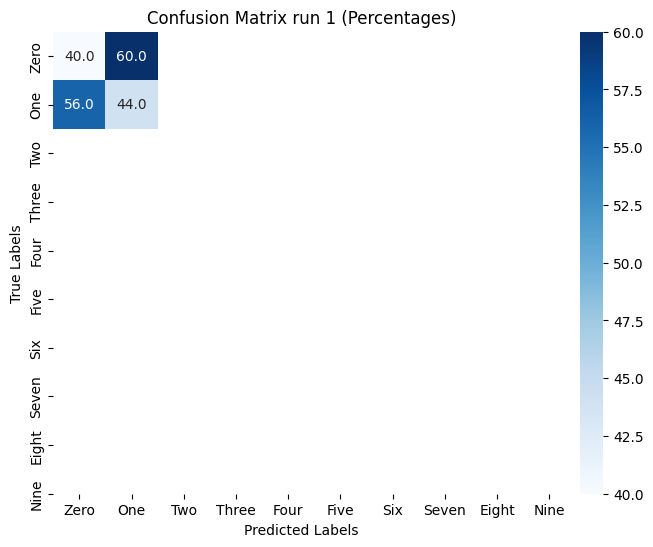

In [512]:
#Confusion Matrix TM 1
conf_matrix1 = confusion_matrix(Y_test, tm.predict(X_test))
# Calculate percentages
conf_matrix_percent1 = conf_matrix1 / conf_matrix1.sum(axis=1, keepdims=True) * 100
conf_matrix_percent1 = np.nan_to_num(conf_matrix_percent1, 0)  # Replace NaNs with 0

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent1, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix run 1 (Percentages)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [513]:
#Patch object

class Patch:
    def __init__(self, xMin, xMax, yMin, yMax, ID, patch_info, raw, weight=None):
        # Coordinates where patch appears
        self.xMin = xMin
        self.xMax = xMax
        self.yMin = yMin
        self.yMax = yMax
        
        self.weight = weight
        self.ID = ID
        self.patch_info = patch_info # color info in 3x3px 3xcolor uint8
        self.raw = raw #bool vals of whole clause
        self.found_in_images = {}
        self.total_count = 0
        self.sparsity = 0
            
    def visualize_patch_info(self, polarity=0):
        # Rescale the channel values to the range of 0-255
        patch_info_scaled = (np.array(self.patch_info) * (255 / resolution)).astype(np.uint8)
        
        # Create an empty image canvas
        image = np.zeros((3, 3, 3), dtype=np.uint32)
        # Loop through each channel
        for c in range(3):
            image[:,:,c] = patch_info_scaled[:,:,c, polarity].reshape((3,3))
        
        return image
    def dominant_color(self, value=0):
        # Reshape the patch to a 9x3 array
        pixels = self.patch_info[...,0].reshape((9, 3))

        # Calculate the sum of color values for each channel
        color_sums = np.sum(pixels, axis=0)

        # Find the index of the channel with the highest sum
        dominant_channel = np.argmax(color_sums)

        # Determine the dominant color based on the channel index
        if dominant_channel == 0:
            dominant_color = 'R'
        elif dominant_channel == 1:
            dominant_color = 'G'
        else:
            dominant_color = 'B'
        
        if value == 1:
            return dominant_channel
        elif value == 2:
            return sum(self.patch_info[:,:,dominant_channel]) // 3
        else:
            return dominant_color
        


def thermometer_to_integer(thermometer_bits, negated = 0):
    value = 0
    thermometer_bits_local = thermometer_bits
    length = len(thermometer_bits_local)
    for bit in range(length):
        if not negated:
            if thermometer_bits_local[bit]:
                value = bit+1
        else:
            if thermometer_bits_local[bit]:
                value = bit
                break
            value = length+1
    return value

#TODO: tm.transform should be moved elsewhere, but transform_clause_to_patch wont compile without it
bank = tm.transform(X_train) # bank is a (image, clause*class) sized array

def transform_clause_to_patch(block, ID, resolution=8, patch_dim=(3,3), image_size=X_train_org.shape[1:3]):
    auxK = 0
    auxJ = image_size[0] - patch_dim[0] -1
    xMin = thermometer_to_integer(block[auxK:auxJ], negated=0)
    auxK = image_size[0] - patch_dim[0]
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
    yMin = thermometer_to_integer(block[auxK:auxJ], negated=0)
    auxK = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0] -1
    xMax = thermometer_to_integer(block[auxK:auxJ], negated=1)
    auxK = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0]
    auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
    yMax = thermometer_to_integer(block[auxK:auxJ], negated=1)
    
    # Sort out the pixels
    patch_info = np.zeros((3,3,3,2)) 
    for column in range(patch_dim[1]):
        # rows = []
        for row in range(patch_dim[0]):
            # colors = []
            for color in range(3):
                auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
                start_bit = auxJ + (column+row) * (3*resolution) + color * resolution
                end_bit = start_bit + resolution
                value = thermometer_to_integer(block[start_bit:end_bit])*(255/resolution)
                
                auxJ = image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] +patch_dim[0]*patch_dim[1]*resolution + image_size[0] - patch_dim[0] + image_size[1] - patch_dim[1] -1
                start_bit2 = auxJ + (column+row) * (3*resolution) + color * resolution
                end_bit2 = start_bit2 + resolution
                value2 = thermometer_to_integer(block[start_bit2:end_bit2], negated=1)*(255/resolution)
                #value = (value + value2)/2
                #if value == 0: # turn the pixel white if empty
                #    value = 8
                patch_info[column,row,color,0] = value
                patch_info[column,row,color,1] = value2
                # colors.append(value)
            # rows.append(colors)
        # patch_info.append(rows)
    raw = block
    weight = 0
    ID = ID
    return Patch(xMin=xMin, xMax=xMax, yMin=yMin, yMax=yMax, weight=weight, ID=ID, patch_info=patch_info, raw=raw)



In [514]:
if not bypass_anchor_selection:
    def find_patches_in_image(image, patches_to_search, targeted_search=False, avg=True):
        """
        Search for specific patches within a given image. Return found ID and coordinates.
        
        Parameters:
        - image: 2D array representing the image.
        - patches_to_search: List of Patch objects to search for in the image.
        - targeted_search: Boolean indicating whether to search only within the patch's expected coordinates.
        - avg: Boolean indicating whether to return average coordinates for each patch.
        
        Returns:
        - results: Array with shape (number of patches, 3) containing the patch ID and its (average) x and y coordinates.
        - found_coordinates: List of tuples containing the coordinates where patches were found.
        """
        results = []
        for patch in patches_to_search:
            patch_info = patch.patch_info
            
            # Define the search area based on the targeted_search flag
            if targeted_search:
                search_area = image[patch.xMin:patch.xMax, patch.yMin:patch.yMax]
                offset_x, offset_y = patch.xMin, patch.yMin
            else:
                search_area = image
                offset_x, offset_y = 0, 0
            
            found_coordinates = []
            for x in range(search_area.shape[0] - patch_info.shape[0] + 1):
                for y in range(search_area.shape[1] - patch_info.shape[1] + 1):
                    region = search_area[x:x+patch_info.shape[0], y:y+patch_info.shape[1]]
                    if np.all(region >= patch_info[...,0]) and np.all(region <= patch_info[...,1]):
                        found_coordinates.append((x + offset_x, y + offset_y))
            
            # Calculate average coordinates if required
            if avg and found_coordinates:
                avg_x = int(np.mean([coord[0] for coord in found_coordinates]))
                avg_y = int(np.mean([coord[1] for coord in found_coordinates]))
                results.append((patch.ID, avg_x, avg_y))
            elif not avg:
                results.append((patch.ID, found_coordinates))
        
        return results


    def find_patches_in_images(images, labels, patches_to_find):
        """
        Use find_patches_in_image function, for the whole batch of images

        Args:
            images (img, x, y, [R,G,B]): _description_
            labels (img, label): _description_
            patches_to_find (_type_): _description_

        Returns:
            _type_: _description_
        """
        num_images = images.shape
        valid_indices = np.where((labels < patches_to_find.shape[0]) & (labels < num_images))[0]
        
        results = [find_patches_in_image(images[i], patches_to_find[labels[i], 0, :], targeted_search=True) for i in tqdm(valid_indices, desc="Processing images", position=0, leave=True)]
        
        return results  # Return the list of arrays directly


def create_dist_and_dir_map(images, Y_images, anchor_points, n_anchor_points=2):
    """
    Encode images based on the distance and angle to the anchor patch.
    
    Parameters:
    - images: List of 2D arrays representing the images.
    - Y_images: List of labels corresponding to each image.
    - anchor_points: List of origin points.[Class, img, coors[x,y]]
    - n_anchor_points: Number of origin points to consider.
    
    Returns:
    - encoded_patches: Array containing the encoded images.
    """
    batch_size, height, width, _ = images.shape
    encoded_patches = np.zeros((batch_size, height, width, tm.number_of_classes, n_anchor_points, 2), dtype=np.uint32)
    
    # if n_anchor_points > 1:
    #     origin_coord = origins[img]
    # else:
    #     origin_coord = origins
    
    for img in range(batch_size):
        for j in range(height):
            for k in range(width):
                for Class in range(tm.number_of_classes):
                    for point in range(n_anchor_points):
                        origin_coord = anchor_points[Class][img]
                        # Check if the origin coordinate is a placeholder
                        if np.any(origin_coord == -1):
                            continue
                        else:
                            distance, angle = calculate_distance_and_direction(origin_coord, (j, k))
                            encoded_patches[img, k, j, Class, point] = [distance, angle]
    return encoded_patches


def scale_value_int(value, old_max, new_max):
    return int((value / old_max) * new_max)


def calculate_distance_and_direction(coord1, coord2):
    #TODO: remove the koeficients and replace with variable adjusting. the scaling now is to fit 0 to 255 scale
    distance = 7* math.sqrt((coord2[0] - coord1[0])**2 + (coord2[1] - coord1[1])**2)
    angle = math.atan2(coord2[1] - coord1[1], coord2[0] - coord1[0])
    print("angle", angle)
    return distance, angle


def calculate_distance_and_direction(coord1, coord2):
    coord1, coord2 = np.array(coord1), np.array(coord2)
    
    # Calculate Euclidean distance
    distance = np.hypot(*(coord2 - coord1))
    # Scale distance to fit 0 to 255 scale
    distance = (distance / 32) * 255

    # Calculate angle
    angle = np.arctan2(coord2[1] - coord1[1], coord2[0] - coord1[0])
    # Shift range to [0, 2π]
    angle = angle % (2 * np.pi)
    # Convert to degrees and scale from [0, 360] to [0, 255]
    angle = (np.degrees(angle) / 360) * 255
    # Convert to uint32
    distance = distance.astype(np.uint32)
    angle = angle.astype(np.uint32)

    #print("distance", distance)
    return distance, angle


In [515]:
#TODO: use the find patches in images function to set the anchor points


In [516]:
if bypass_anchor_selection:

    print("Bypassing the search of anchor points")
    anchors_test = np.empty((tm.number_of_classes, X_test.shape[0], coors_test_org.shape[1]))

    for Class in range(tm.number_of_classes):
        for img in range(X_test.shape[0]):
            anchors_test[Class, img] = coors_test_org[img, :]

    encoded_patches_test = create_dist_and_dir_map(X_test_org, Y_test_org, anchors_test, 1)


else:
    # Find anchors on test data
    counts = np.zeros((tm.number_of_clauses*tm.number_of_classes))
    for image_results in X_test_all_results:
        for patch in image_results:
            patch_id = patch[0]
            counts[patch_id] += 1
    anchors_id = []
    # Initialize anchor_points
    anchor_points = [[] for _ in range(tm.number_of_classes)]
    # Get anchor points for each class
    for Class in range(tm.number_of_classes):
        #anchor_ids = Class*tm.number_of_clauses + counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses].argsort()[-2:]
        anchor_ids = Class*tm.number_of_clauses + counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses].argsort()
        #IDs now per class
        for anchor_id in anchor_ids: #per ID
            # Find the coordinates of the anchor patches
            for image_results in X_test_all_results: 
                for result in image_results:
                    # if bypass_anchor_selection:
                    #     anchor_points[Class].append(coors_test_org[img, :].tolist())  # Assuming result[1] has the coordinates
                    # else:
                    if result[0] == anchor_id:
                        anchor_points[Class].append(result[1:])
                    else:
                        anchor_points[Class].append([0,0]) 
    encoded_patches_test = create_dist_and_dir_map(X_test_org, Y_test_org, anchor_points, 2)
    


Bypassing the search of anchor points


In [517]:
if bypass_anchor_selection:
    print("Bypassing the search of anchor points")
    anchors_train = np.empty((tm.number_of_classes, X_train.shape[0], coors_train_org.shape[1]))

    for Class in range(tm.number_of_classes):
        for img in range(X_train.shape[0]):
            anchors_train[Class, img] = coors_train_org[img, :]

    encoded_patches_train = create_dist_and_dir_map(X_train_org, Y_train_org, anchors_train, 1)
else:
    #find anchors on train data
    counts = np.zeros((tm.number_of_clauses*tm.number_of_classes))
    for image_results in X_train_all_results:
        for patch in image_results:
            patch_id = patch[0]
            counts[patch_id] += 1
    anchors_id = []
    # Initialize anchor_points
    anchor_points = [[] for _ in range(tm.number_of_classes)]
    # Get anchor points for each class
    for Class in range(tm.number_of_classes):
        #anchor_ids = Class*tm.number_of_clauses + counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses].argsort()[-2:]
        anchor_ids = Class*tm.number_of_clauses + counts[Class*tm.number_of_clauses:(Class+1)*tm.number_of_clauses]
        #IDs now per class
        for anchor_id in anchor_ids: #per ID
            # Find the coordinates of the anchor patches
            for image_results in X_train_all_results:
                for result in image_results:
                    if result[0] == anchor_id:
                        anchor_points[Class].append(result[1:])  # Assuming result[1] has the coordinates
                    else:
                        anchor_points[Class].append([0,0]) 
    encoded_patches_train = create_dist_and_dir_map(X_train_org, Y_train_org, anchor_points, 2)




Bypassing the search of anchor points


(3, 50, 2)
(3, 50, 2)
test:


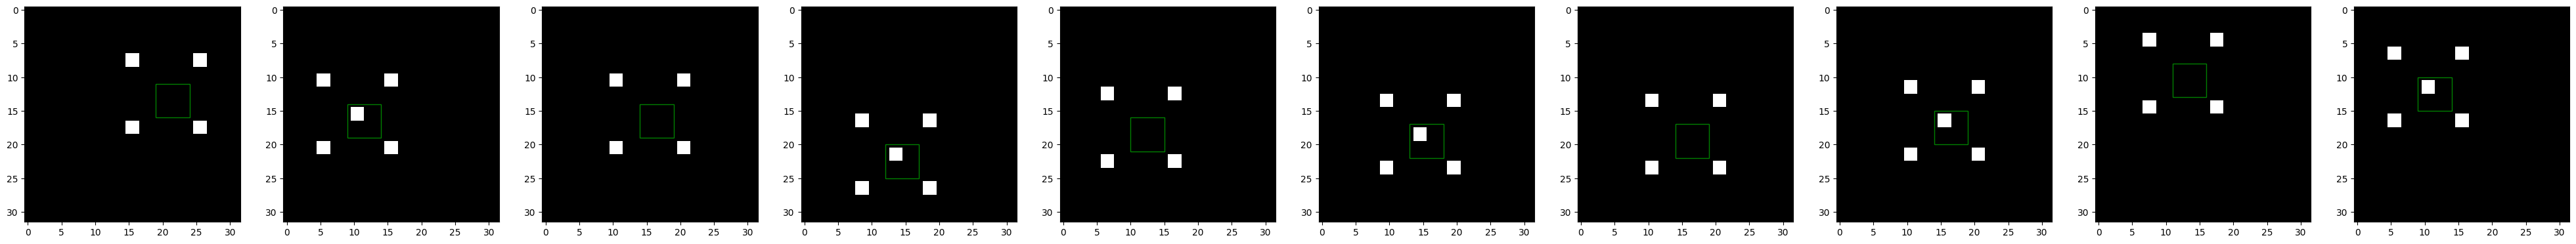

train:


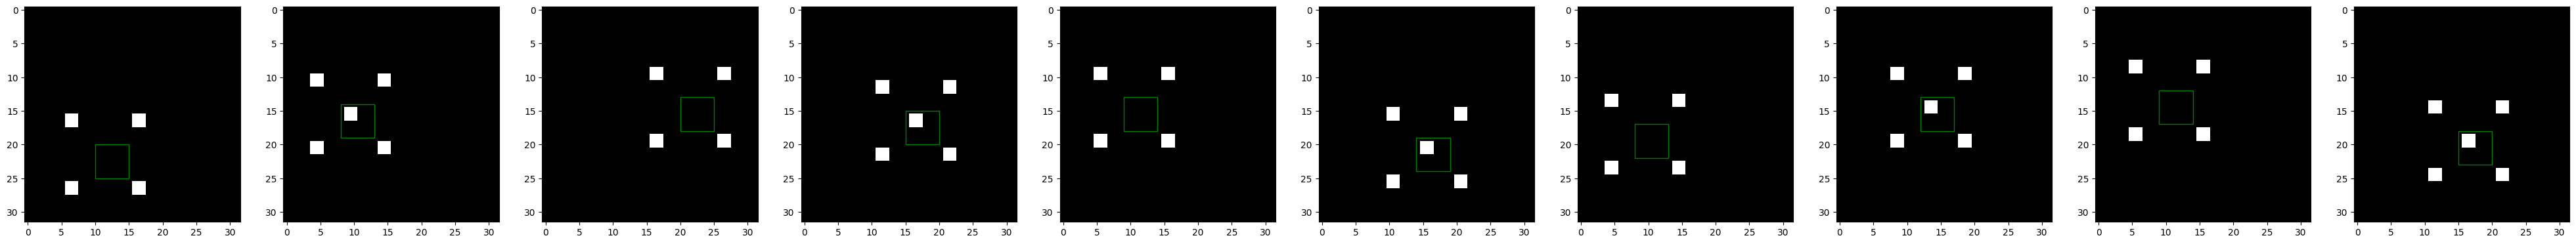

In [518]:
def plot_images_with_coordinates(images, Y_images, anchor_points, n_anchor_points=6, square_size=5):
    """
    Plots images with specified coordinates (anchor points) marked with red squares based on their class labels.

    Parameters:
    - images: numpy array of 2D arrays representing the images.
    - Y_images: numpy array of labels corresponding to each image.
    - anchor_points: numpy array of origin points for each class.
    - n_anchor_points: Number of origin points to consider for each class.
    - square_size: Size of the square to be plotted at each coordinate.
    """
    
    batch_size = images.shape[0]
    fig, ax = plt.subplots(1, batch_size, figsize=(batch_size * 5, 5))

    if batch_size == 1:
        ax = [ax]

    for i in range(batch_size):
        ax[i].imshow(images[i])
        class_label = Y_images[i, 0] if len(Y_images.shape) > 1 else Y_images[i]

        if class_label < anchor_points.shape[0]:
            origins = anchor_points[class_label]
            origin_coord = origins[i]
            if np.any(origin_coord == -1):
                continue
            x, y = origin_coord
            rect = patches.Rectangle((x - square_size//2, y - square_size//2), square_size, square_size, linewidth=1, edgecolor='g', facecolor='none')
            ax[i].add_patch(rect)

    plt.show()
#print("te:", anchors_test[:1])
print(anchors_test.shape)

#print("tr:", anchors_train)
print(anchors_train.shape)
print("test:")
plot_images_with_coordinates(X_test_org[:10], Y_test_org, anchors_test)
print("train:")
plot_images_with_coordinates(X_train_org[:10], Y_train_org, anchors_train)


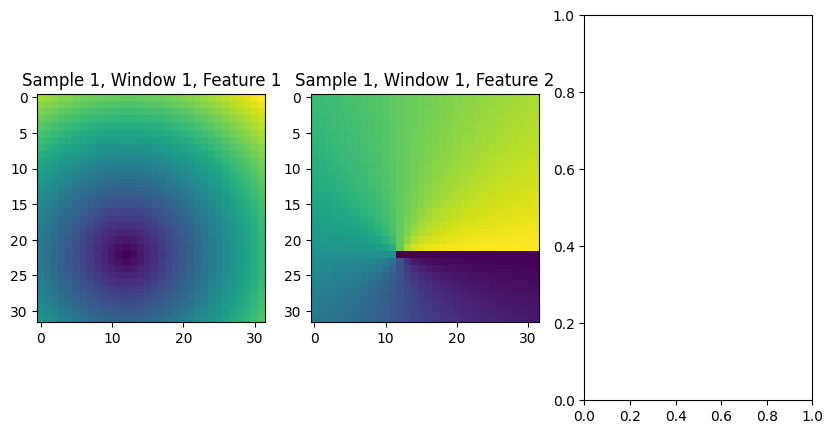

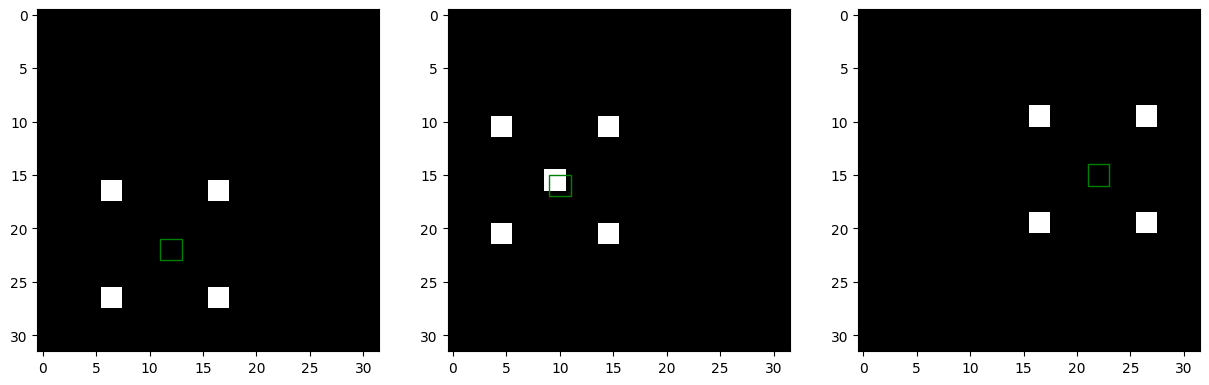

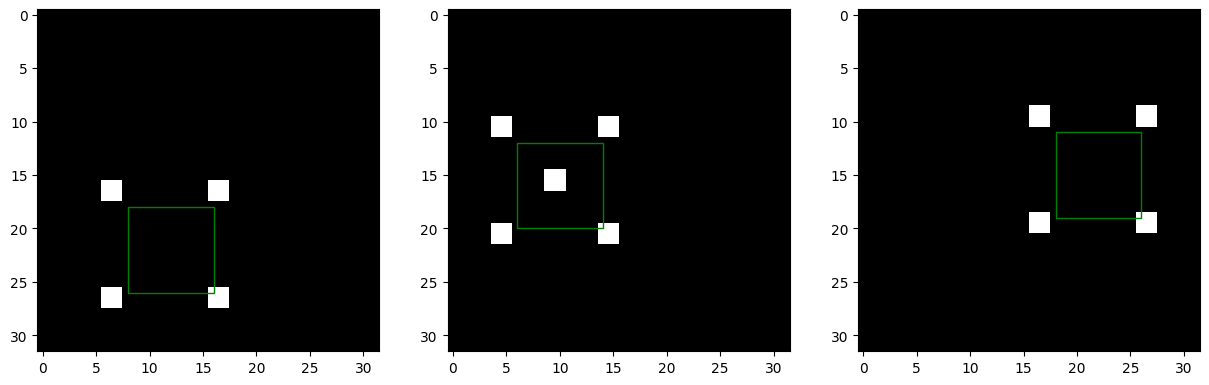

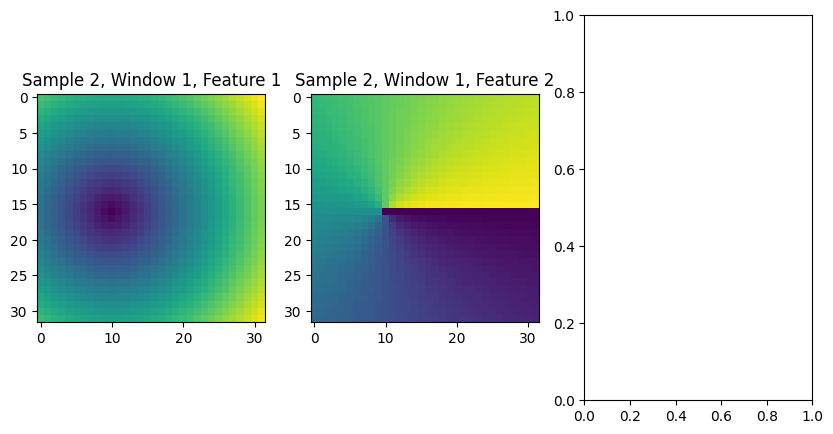

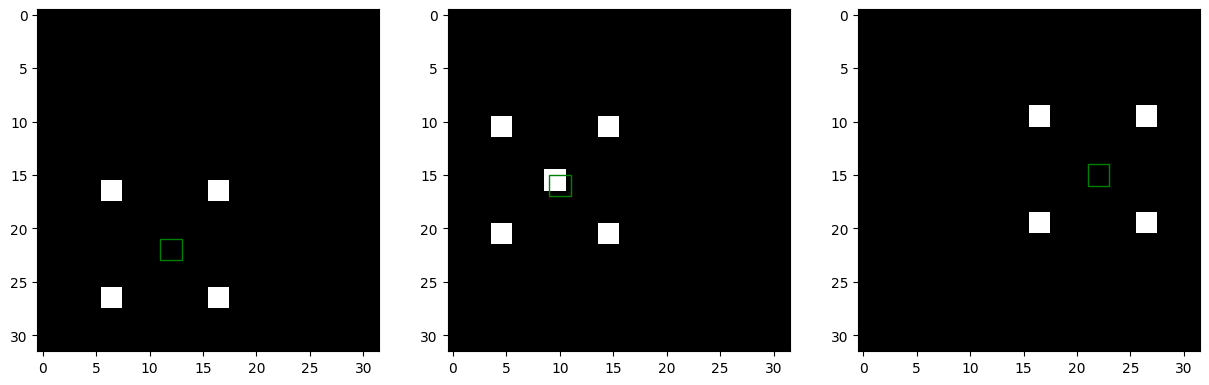

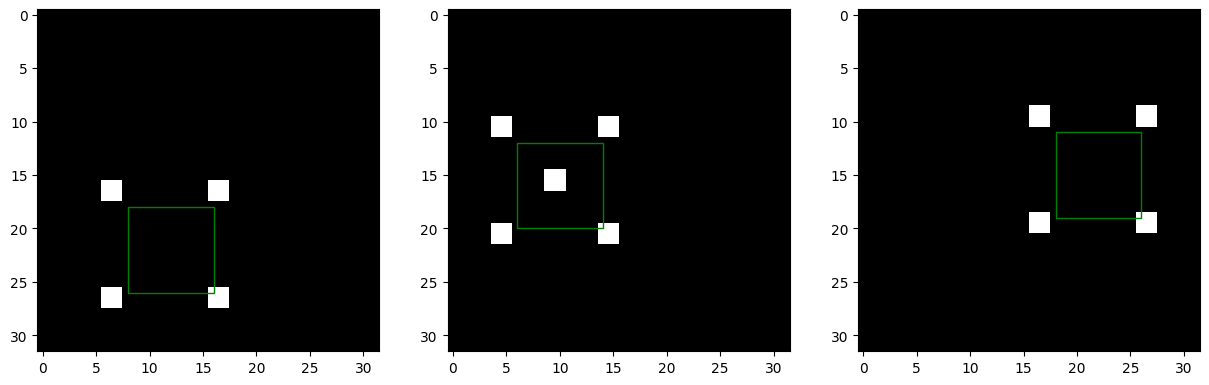

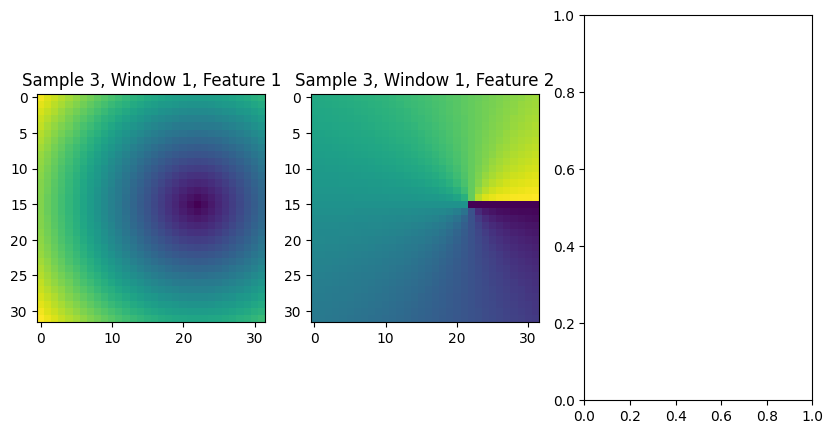

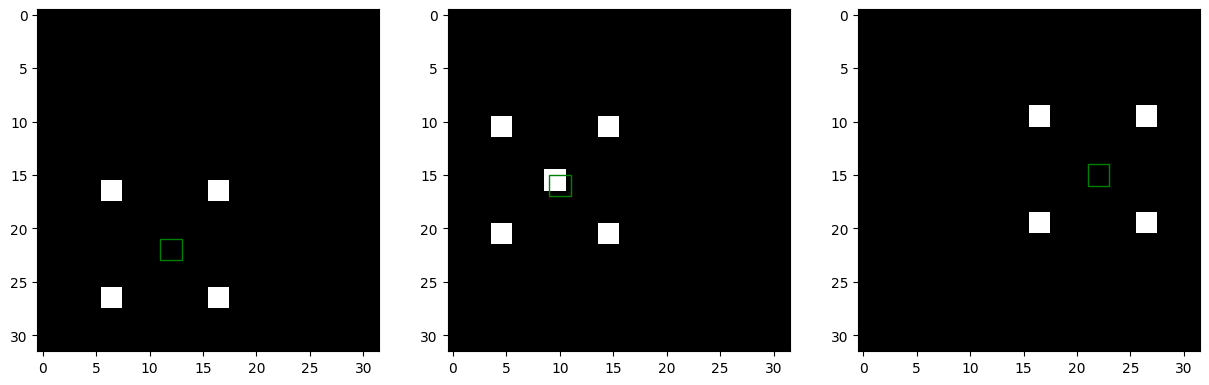

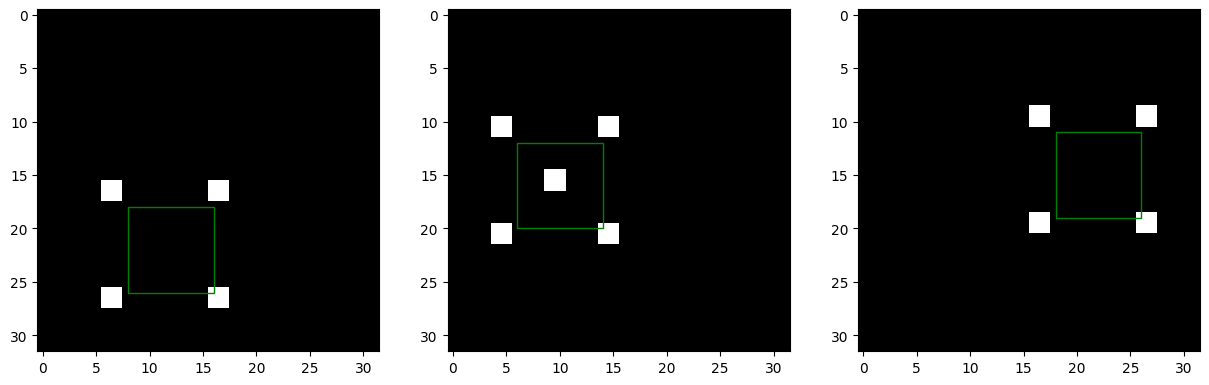

In [519]:
# Select a few sample images
samples = encoded_patches_train[:3]
for i, sample in enumerate(samples):
    for j in range(1):  # Second last dimension (windows)
        # Create a new figure for each window
        plt.figure(figsize=(10, 5))

        for k in range(2):  # Last dimension (features)
            # Create a subplot for each feature
            plt.subplot(1, 3, k + 1)
            plt.imshow(sample[...,j, 0, k])  # Set aspect to 'auto'
            plt.title(f'Sample {i+1}, Window {j+1}, Feature {k+1}')
        
        # Plot the corresponding image with anchor points
        plt.subplot(1, 3, 3)
        plot_images_with_coordinates(X_train_org[:3], Y_train_org, anchors_train,square_size=2)
        plot_images_with_coordinates(X_train_org[:3], Y_train_org, anchors_train,square_size=8)
        
        plt.show()
    

In [520]:
# Create the windowed datasets
X_train2 = create_windowed_dataset(thermometer_encode(X_train_org,resolution=4), thermometer_encode(encoded_patches_train, resolution=14), patch_dim=patch_dim)
X_test2 = create_windowed_dataset(thermometer_encode(X_test_org,resolution=4), thermometer_encode(encoded_patches_test, resolution=14), patch_dim=patch_dim)

In [521]:
#USE UINT32

#Train the TM 2 and record results
#f = open("run_%.1f_%d_%d_%d_%d_%d.txt" % (s, clauses, T, step, visual_tokens), "w+")
logTrain = np.zeros((epochs, X_train2.shape[0]), dtype=np.uint8)
logTest =  np.zeros((epochs, X_test2.shape[0]),  dtype=np.uint8)

print("Training:")
training_data_labels = np.unique(Y_train)
print(training_data_labels.shape[0], "labels used:", training_data_labels)
print("Training pictures:", X_train2.shape[0])

print("Testing:")
testing_data_labels = np.unique(Y_test)
print(testing_data_labels.shape[0], "labels used:", testing_data_labels)
print("Maximum achievable accuracy:", (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
print("..adjusting") #see result_test_adj
print("Testing pictures:", X_test2.shape[0])

for label in range(trained_labels.shape[0]):
        print("\nAccuracy over %d epochs:\n" % (epochs))

        tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, patch_dim=(1,1), platform='CPU', weighted_clauses=True)
        
        for epoch in tqdm(range(epochs)):
                start_training = time()
                tm.fit(X_train2, Y_train)
                stop_training = time()

                start_testing = time()
                result_test = 100*(tm.predict(X_test2) == Y_test).mean()
                result_test_adj = 100*(result_test/ (100*(training_data_labels.shape[0]/testing_data_labels.shape[0])))
                logTest[epoch] = (tm.predict(X_test2))*label
                stop_testing = time()

                result_train = 100*(tm.predict(X_train2) == Y_train).mean()
                logTrain[epoch] = (tm.predict(X_train2))*label

                #recall_and_precision(epoch)

                print("%d %d %.2f %.2f %.2f %.2f" % (label, epoch, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing))
                #print("%d %d %.2f %.2f %.2f %.2f" % (label, epoch, result_test_adj, result_train, stop_training-start_training, stop_testing-start_testing), file=f)
                #f.flush()
#f.close()



Training:
2 labels used: [1 2]
Training pictures: 50
Testing:
2 labels used: [1 2]
Maximum achievable accuracy: 100.0
..adjusting
Testing pictures: 50

Accuracy over 20 epochs:



  0%|          | 0/20 [00:00<?, ?it/s]

2024-01-05 20:45:40,581 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  5%|▌         | 1/20 [00:09<02:59,  9.44s/it]

0 0 50.00 50.00 1.52 4.02


 10%|█         | 2/20 [00:18<02:41,  8.98s/it]

0 1 50.00 50.00 0.45 4.32


 15%|█▌        | 3/20 [00:26<02:30,  8.84s/it]

0 2 54.00 60.00 0.43 4.33


 20%|██        | 4/20 [00:35<02:19,  8.74s/it]

0 3 48.00 48.00 0.37 4.27


 25%|██▌       | 5/20 [00:43<02:10,  8.70s/it]

0 4 50.00 60.00 0.36 4.26


 30%|███       | 6/20 [00:52<02:01,  8.69s/it]

0 5 50.00 50.00 0.40 4.36


 35%|███▌      | 7/20 [01:01<01:52,  8.65s/it]

0 6 50.00 60.00 0.37 4.25


 40%|████      | 8/20 [01:09<01:43,  8.65s/it]

0 7 50.00 54.00 0.39 4.32


 45%|████▌     | 9/20 [01:18<01:35,  8.66s/it]

0 8 50.00 50.00 0.40 4.30


 50%|█████     | 10/20 [01:27<01:26,  8.65s/it]

0 9 50.00 50.00 0.37 4.35


 55%|█████▌    | 11/20 [01:35<01:17,  8.63s/it]

0 10 52.00 56.00 0.38 4.27


 60%|██████    | 12/20 [01:44<01:09,  8.64s/it]

0 11 44.00 56.00 0.39 4.27


 65%|██████▌   | 13/20 [01:53<01:00,  8.62s/it]

0 12 52.00 64.00 0.38 4.29


 70%|███████   | 14/20 [02:01<00:51,  8.60s/it]

0 13 48.00 60.00 0.37 4.24


 75%|███████▌  | 15/20 [02:10<00:43,  8.60s/it]

0 14 42.00 56.00 0.38 4.29


 80%|████████  | 16/20 [02:18<00:34,  8.62s/it]

0 15 50.00 56.00 0.37 4.31


 85%|████████▌ | 17/20 [02:27<00:25,  8.61s/it]

0 16 50.00 64.00 0.37 4.31


 90%|█████████ | 18/20 [02:35<00:17,  8.58s/it]

0 17 54.00 54.00 0.38 4.20


 95%|█████████▌| 19/20 [02:44<00:08,  8.57s/it]

0 18 50.00 62.00 0.39 4.27


100%|██████████| 20/20 [02:53<00:00,  8.66s/it]


0 19 48.00 62.00 0.37 4.33

Accuracy over 20 epochs:



  0%|          | 0/20 [00:00<?, ?it/s]

2024-01-05 20:48:33,726 - tmu.models.classification.base_classification - DEBUG - Initializing clause bank....


  5%|▌         | 1/20 [00:08<02:46,  8.76s/it]

1 0 50.00 50.00 1.05 3.86


 10%|█         | 2/20 [00:17<02:36,  8.68s/it]

1 1 48.00 52.00 0.42 4.24


 15%|█▌        | 3/20 [00:26<02:27,  8.67s/it]

1 2 50.00 50.00 0.40 4.31


 20%|██        | 4/20 [00:34<02:18,  8.63s/it]

1 3 46.00 56.00 0.39 4.29


 25%|██▌       | 5/20 [00:43<02:09,  8.62s/it]

1 4 58.00 58.00 0.40 4.29


 30%|███       | 6/20 [00:51<02:00,  8.60s/it]

1 5 58.00 58.00 0.37 4.27


 35%|███▌      | 7/20 [01:00<01:52,  8.62s/it]

1 6 50.00 50.00 0.40 4.29


 40%|████      | 8/20 [01:08<01:43,  8.60s/it]

1 7 54.00 58.00 0.36 4.24


 45%|████▌     | 9/20 [01:17<01:34,  8.60s/it]

1 8 52.00 52.00 0.36 4.31


 50%|█████     | 10/20 [01:26<01:26,  8.60s/it]

1 9 52.00 52.00 0.37 4.27


 55%|█████▌    | 11/20 [01:34<01:17,  8.61s/it]

1 10 56.00 66.00 0.36 4.35


 60%|██████    | 12/20 [01:43<01:08,  8.61s/it]

1 11 64.00 74.00 0.41 4.29


 65%|██████▌   | 13/20 [01:52<01:00,  8.65s/it]

1 12 66.00 74.00 0.39 4.35


 70%|███████   | 14/20 [02:00<00:52,  8.67s/it]

1 13 54.00 60.00 0.40 4.34


 75%|███████▌  | 15/20 [02:09<00:43,  8.67s/it]

1 14 58.00 70.00 0.36 4.35


 80%|████████  | 16/20 [02:18<00:34,  8.65s/it]

1 15 86.00 94.00 0.37 4.29


 85%|████████▌ | 17/20 [02:26<00:25,  8.63s/it]

1 16 68.00 82.00 0.39 4.27


 90%|█████████ | 18/20 [02:35<00:17,  8.64s/it]

1 17 98.00 98.00 0.40 4.28


 95%|█████████▌| 19/20 [02:43<00:08,  8.61s/it]

1 18 88.00 88.00 0.35 4.23


100%|██████████| 20/20 [02:52<00:00,  8.64s/it]

1 19 92.00 92.00 0.44 4.39


2024-01-05 20:51:29,525 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x298e52110>


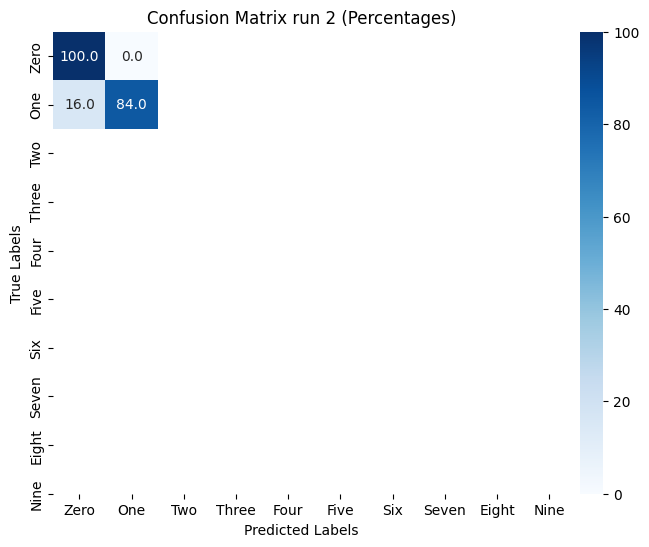

In [522]:
#Confusion Matrix
conf_matrix2 = confusion_matrix(Y_test, tm.predict(X_test2))
# Calculate percentages
conf_matrix_percent2 = conf_matrix2 / conf_matrix2.sum(axis=1, keepdims=True) * 100
conf_matrix_percent2 = np.nan_to_num(conf_matrix_percent2, 0)  # Replace NaNs with 0

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent2, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix run 2 (Percentages)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


2024-01-05 20:51:29,646 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x299be1480>


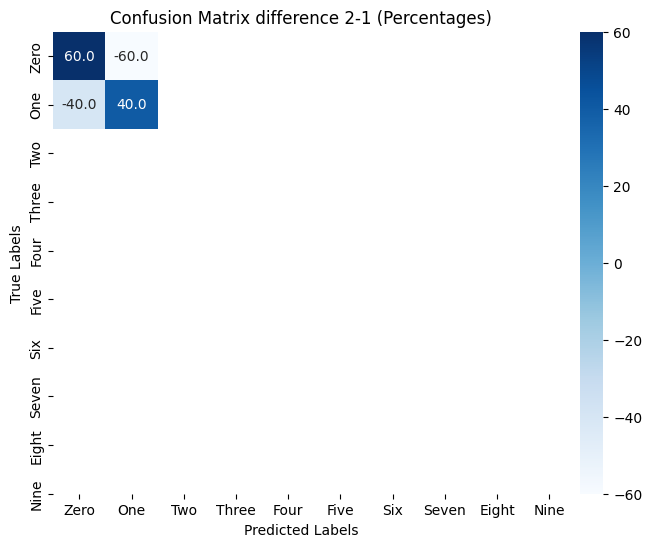

In [523]:
#Confusion Matrix

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent2-conf_matrix_percent1, annot=True, fmt=".1f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix difference 2-1 (Percentages)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
